In [1]:
import sys

print(sys.executable)

/usr/bin/python3


# SETUP

In [2]:
# Matt
import os
import sys

# sys.path.append(os.path.abspath('../combots-venv-new/lib/python3.12/site-packages'))
%pip install cltl.combot --break-system-packages
%pip install python-dotenv
from dotenv import load_dotenv

# Get the current working directory
current_dir = os.getcwd()
# Construct the relative path to the .env file
env_path = os.path.join(current_dir, "../.env")
# Load the .env file
load_dotenv(env_path)


# OpenAI API Key
api_key = os.getenv("OPENAI_API_KEY")

ERROR: Operation cancelled by user


In [3]:
# Colab
%pip install --upgrade ai2thor --quiet
%pip install ai2thor-colab prior --upgrade &> /dev/null
%pip install python-dotenv
%pip install cltl.combot --break-system-packages
import os

os.system("apt-get install xvfb")
import ai2thor_colab

ai2thor_colab.start_xserver()

from dotenv import load_dotenv

# Load the .env file
load_dotenv()

# OpenAI API Key
api_key = os.getenv("OPENAI_API_KEY")

In [ ]:
def setup(env="colab"):
    if env == "colab":
        # Colab
        %pip install --upgrade ai2thor --quiet
        %pip install ai2thor-colab prior --upgrade &> /dev/null
        %pip install python-dotenv
        %pip install cltl.combot --break-system-packages
        import os
        
        os.system("apt-get install xvfb")
        import ai2thor_colab
        
        ai2thor_colab.start_xserver()
        
        from dotenv import load_dotenv
        
        # Load the .env file
        load_dotenv()
        
        # OpenAI API Key
        api_key = os.getenv("OPENAI_API_KEY")
    if env == "local":
        # Matt
        import os
        import sys
        
        # sys.path.append(os.path.abspath('../combots-venv-new/lib/python3.12/site-packages'))
        %pip install cltl.combot --break-system-packages
        %pip install python-dotenv
        from dotenv import load_dotenv
        
        # Get the current working directory
        current_dir = os.getcwd()
        # Construct the relative path to the .env file
        env_path = os.path.join(current_dir, "../.env")
        # Load the .env file
        load_dotenv(env_path)
        
        
        # OpenAI API Key
        api_key = os.getenv("OPENAI_API_KEY")

In [4]:
import prior

dataset = prior.load_dataset("procthor-10k")
dataset

[AI2-THOR WARNING] There has been an update to ProcTHOR-10K that must be used with AI2-THOR version 5.0+. To use the new version of ProcTHOR-10K, please update AI2-THOR to version 5.0+ by running:
    pip install --upgrade ai2thor
Alternatively, to downgrade to the old version of ProcTHOR-10K, run:
   prior.load_dataset("procthor-10k", revision="ab3cacd0fc17754d4c080a3fd50b18395fae8647")


Loading test: 100%|██████████| 1000/1000 [00:00<00:00, 1195.10it/s]


DatasetDict(
    train=Dataset(
    dataset=procthor-dataset,
    size=10000,
    split=train
),
    val=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=val
),
    test=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=test
)
)

In [5]:
house = dataset["train"][11]# CHOOSE HOUSE

In [ ]:
def load_dataset(house:int=11):
    import prior
    dataset = prior.load_dataset("procthor-10k")
    house = dataset["train"][house]# CHOOSE HOUSE

In [6]:
from ai2thor.controller import Controller
from PIL import Image

In [7]:
controller = Controller(scene=house, visibilityDistance=10, width=750, height=750)

In [8]:
import copy

def get_top_down_frame():
    # Setup the top-down camera
    event = controller.step(action="GetMapViewCameraProperties", raise_for_failure=True)
    pose = copy.deepcopy(event.metadata["actionReturn"])

    bounds = event.metadata["sceneBounds"]["size"]
    max_bound = max(bounds["x"], bounds["z"])

    pose["fieldOfView"] = 50
    pose["position"]["y"] += 1.1 * max_bound
    pose["orthographic"] = False
    pose["farClippingPlane"] = 50
    del pose["orthographicSize"]

    # add the camera to the scene
    event = controller.step(
        action="AddThirdPartyCamera",
        **pose,
        skyboxColor="white",
        raise_for_failure=True,
    )
    top_down_frame = event.third_party_camera_frames[-1]
    return Image.fromarray(top_down_frame)


# get_top_down_frame()

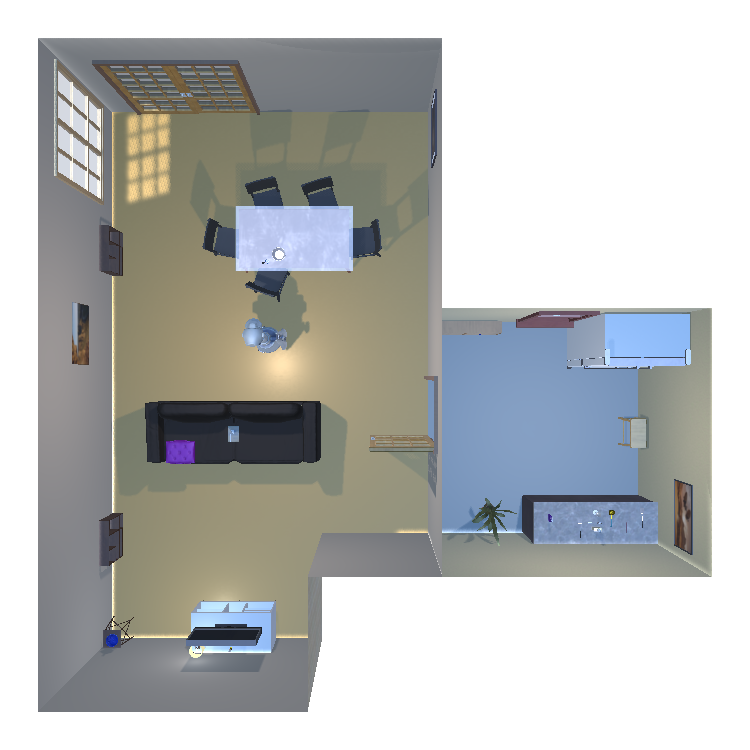

In [9]:
# new_house = dataset["train"][666]
# controller.reset(scene=new_house)
get_top_down_frame()

In [10]:
event = controller.step(action="GetReachablePositions")
reachable_positions = event.metadata["actionReturn"]

In [11]:
from openaiapi import analyze_image, analyze_prompt
from utils import numpy_to_base64

frame = controller.last_event.frame
base64_string = numpy_to_base64(frame)

# FUNCTIONS

In [12]:
import math


def teleport_in_front_of_object(
    controller, object_position, reachable_positions, distance=1.0
):
    """Teleports the agent to the closest reachable position in front of an object.

    Args:
      controller: The AI2Thor controller.
      object_position: The position of the target object.
      reachable_positions: A list of reachable positions in the scene.
      distance: The desired distance in front of the object.

    Returns:
      The event after teleporting.
    """

    # Calculate the target position in front of the object
    target_position = {
        "x": object_position["x"] - distance,
        "y": object_position["y"],
        "z": object_position["z"],
    }

    # Find the closest reachable position
    closest_position = None
    min_distance = float("inf")

    for position in reachable_positions:
        dist = math.sqrt(
            (position["x"] - target_position["x"]) ** 2
            + (position["z"] - target_position["z"]) ** 2
        )
        if dist < min_distance:
            min_distance = dist
            closest_position = position

    # Calculate rotation towards the object
    dx = object_position["x"] - closest_position["x"]
    dz = object_position["z"] - closest_position["z"]
    rotation = math.degrees(math.atan2(dx, dz))

    # Teleport and rotate
    event = controller.step(
        action="Teleport", position=closest_position, rotation=rotation
    )
    agent_position = controller.last_event.metadata['agent']['position']
    visited_positions.append(agent_position)

    return event  # Return the event after adjusting view angle

In [13]:
def get_object_positions(controller, matched_object):
    """
    Finds the positions of all visible objects of a specific type.

    Args:
      controller: The AI2Thor controller.
      matched_object: The type of object to find (e.g., "Painting", "Chair", "Table").

    Returns:
      A list of positions for the specified object type.
    """
    visible_objects = [
        obj for obj in controller.last_event.metadata["objects"] if obj["visible"]
    ]
    objects_of_interest = [
        obj for obj in visible_objects if obj["objectType"] == matched_object
    ]
    object_positions = []
    for obj in objects_of_interest:
        # print(obj["name"], obj["position"])
        object_positions.append(obj["position"])
    return object_positions

In [14]:
import re


def interactive_object_match(
    api_key: str,
    human_object_description: str,
    unique_object_list: list,
    HUMAN: str,
    AGENT: str,
    leolaniClient,
):
    """
    Interactively matches a human description of an object to one from a given list using an LLM.
    The function continues to refine guesses based on user confirmation or denial.

    Args:
        api_key (str): The API key for accessing the LLM.
        human_object_description (str): A description of the object to match.
        unique_object_list (list): The list of unique objects to match against.

    Returns:
        str: The confirmed object from the user.
        list: The matched object(s) from the list based on the LLM's response.
    """

    def ask_llm(description: str, objects: list) -> str:
        """Helper function to query the LLM for matching the description."""
        object_list_str = ", ".join(objects)
        prompt = (
            f"Imagine you are tasked with identifying an object from a given list based on its description. "
            f"The list of objects is: {object_list_str}. "
            f"Your task is to match the following description to one or more objects from the list: \n"
            f"'{description}'\n\n"
            "If you have a single best guess, respond with: 'To be sure, would you describe your object as {object}? '\n"
            "If you are unsure and need clarification between a few options, respond with: "
            "'To be sure, would you describe your object as {object1} or {object2}? '"
            "Only use objects from the list."
        )
        # Make sure the response is extracted correctly from the LLM
        llm_response = analyze_prompt(api_key=api_key, prompt=prompt)

        if isinstance(llm_response, tuple):
            llm_response = llm_response[0]

        if (
            isinstance(llm_response, list) and llm_response
        ):  # Check if it's a non-empty list
            llm_response = llm_response[0]  # Access the first element if it's a list

        if (
            isinstance(llm_response, dict)
            and "choices" in llm_response
            and llm_response["choices"]
        ):
            return llm_response["choices"][0]["message"]["content"]
        return llm_response  # Return raw response if format is unexpected

    current_description = human_object_description

    while True:
        # Query the LLM for a guess
        response = ask_llm(current_description, unique_object_list)
        leolaniClient._add_utterance(AGENT, response)
        print(f"{AGENT}>{response}")

        # Extract the matched object(s) from the response
        matched_objects = re.findall(
            r"\b(" + "|".join(map(re.escape, unique_object_list)) + r")\b", response
        )

        if matched_objects:
            # Ask the user for confirmation or denial
            confirmation_prompt = f"Is this correct? (yes/no): "
            leolaniClient._add_utterance(AGENT, confirmation_prompt)
            print(f"{AGENT}>{confirmation_prompt}")
            user_input = input().strip().lower()
            leolaniClient._add_utterance(HUMAN, user_input)
            print(f"{HUMAN}>{user_input}")

            if user_input == "yes":
                success_message = "Great! Object successfully matched."
                leolaniClient._add_utterance(AGENT, success_message)
                print(f"{AGENT}>{success_message}")
                return (
                    matched_objects[0] if len(matched_objects) == 1 else matched_objects
                )
            elif user_input == "no":
                refine_message = "Let's refine the search. Can you provide more details or clarify the description?"
                leolaniClient._add_utterance(AGENT, refine_message)
                print(f"{AGENT}>{refine_message}")
                clarifying_question = input().strip()
                leolaniClient._add_utterance(HUMAN, clarifying_question)
                print(f"{HUMAN}>{clarifying_question}")
                current_description = (
                    clarifying_question  # Update the description with the new input
                )
            else:
                error_message = "Please respond with 'yes' or 'no'."
                leolaniClient._add_utterance(AGENT, error_message)
                print(f"{AGENT}>{error_message}")
        else:
            error_message = (
                "I couldn't find a matching object. Can you provide more details?"
            )
            leolaniClient._add_utterance(AGENT, error_message)
            print(f"{AGENT}>{error_message}")
            clarifying_question = input().strip()
            leolaniClient._add_utterance(HUMAN, clarifying_question)
            print(f"{HUMAN}>{clarifying_question}")
            current_description += " " + clarifying_question

In [15]:
def find_all_object_positions(controller, object_type, num_rotations=3):
    """
    Finds the positions of all objects of a specific type by rotating the agent.

    Args:
      controller: The AI2Thor controller.
      object_type: The type of object to find (e.g., "Painting", "Chair", "Table").
      num_rotations: The number of times to rotate the agent to scan for objects.

    Returns:
      A list of positions for the specified object type.
    """
    all_object_positions = []  # To store all object positions

    for _ in range(num_rotations):  # Rotate specified number of times
        # Get visible objects and their positions
        visible_objects = [
            obj for obj in controller.last_event.metadata["objects"] if obj["visible"]
        ]
        objects_of_interest = [
            obj for obj in visible_objects if obj["objectType"] == object_type
        ]
        current_object_positions = []
        for obj in objects_of_interest:
            print(obj["name"], obj["position"])  # Optional: Print object details
            current_object_positions.append(obj["position"])

        # Add current object positions to the overall list
        all_object_positions.extend(current_object_positions)

        # Rotate the agent
        controller.step("RotateRight")

    return all_object_positions


In [16]:
def teleport_to_pos(pos):
    """
    Teleports the agent to a given position and updates the visited_positions list.

    Args:
        pos (dict): The position to teleport to.
    """
    print(f"Teleporting to position: {pos}")
    # rotation = random.choice(range(0, 360, 90))  # Optional: choose a rotation
    event = controller.step(action="Teleport", position=pos, rotation=rotation)
    agent_position = controller.last_event.metadata['agent']['position']
    visited_positions.append(agent_position)

In [17]:
def euclidean_distance_2d(pos1, pos2):
    """
    Calculate the Euclidean distance between two positions in 2D space (x and z axes).

    Args:
        pos1 (dict): The first position with 'x' and 'z' coordinates.
        pos2 (dict): The second position with 'x' and 'z' coordinates.

    Returns:
        float: The Euclidean distance between the two positions.
    """
    return math.sqrt((pos1['x'] - pos2['x'])**2 + (pos1['z'] - pos2['z'])**2)

In [18]:
def get_farthest_position(reachable_positions, visited_positions):
    """
    Find the reachable position that is farthest from any of the visited positions.

    Args:
        reachable_positions (list): A list of reachable positions (each position is a dict with 'x', 'y', 'z').
        visited_positions (list): A list of positions already visited.

    Returns:
        dict: The position in reachable_positions that is farthest from visited_positions.
    """
    max_min_distance = -1
    farthest_position = None
    for position in reachable_positions:
        # Compute distances to all visited positions
        distances = [euclidean_distance_2d(position, visited_pos) for visited_pos in visited_positions]
        # Find the minimum distance to the visited positions
        min_distance = min(distances)
        # Update if this is the farthest minimum distance found so far
        if min_distance > max_min_distance:
            max_min_distance = min_distance
            farthest_position = position
    return farthest_position

In [19]:
import matplotlib.pyplot as plt
def plot_trajectory(reachable_positions, visited_positions, farthest_position):
    # Extract x and z coordinates
    visited_x = [pos['x'] for pos in visited_positions]
    visited_z = [pos['z'] for pos in visited_positions]
    reachable_x = [pos['x'] for pos in reachable_positions]
    reachable_z = [pos['z'] for pos in reachable_positions]

    # Plot the positions
    plt.figure(figsize=(10, 8))
    plt.scatter(reachable_x, reachable_z, c='blue', label='Reachable Positions')
    plt.scatter(visited_x, visited_z, c='red', label='Visited Positions')
    if farthest_position:
        plt.scatter(farthest_position['x'], farthest_position['z'], c='green', label='Farthest Position', s=100)
    plt.xlabel('X coordinate')
    plt.ylabel('Z coordinate')
    plt.title('Positions in the Environment')
    plt.legend()
    plt.grid(True)
    plt.show()

In [20]:
def find_object_and_confirm(
    controller,
    matched_object,
    reachable_positions,
    api_key,
    AGENT,
    HUMAN,
    leolaniClient,
    visited_positions,
    max_rotations=3
):
    """
    Searches for the matched_object in the environment and asks the user for confirmation.
    If the object is not found, it teleports to the farthest away position and continues the search.

    Args:
        controller: The AI2Thor controller instance.
        matched_object (str): The type of object to search for (e.g., "Painting").
        reachable_positions (list): List of reachable positions in the environment.
        api_key (str): API key for the OpenAI API.
        AGENT (str): Name of the agent (e.g., "Ai2Thor").
        HUMAN (str): Name of the human user.
        leolaniClient: Instance of LeolaniChatClient for communication.
        visited_positions (list): List of positions the agent has visited.
        max_rotations (int): Number of rotations to perform when searching for objects.

    Returns:
        bool: True if the object was found and confirmed by the user, False otherwise.
    """

    # Keep track of positions where the object has been searched for
    searched_positions = []

    while True:
        # Find all positions of the matched object in the current view
        object_positions = find_all_object_positions(controller, matched_object, num_rotations=max_rotations)

        # If no objects are found in the current location
        if not object_positions:
            # Check if all reachable positions have been visited
            if len(visited_positions) == len(reachable_positions):
                print(f"{AGENT}>I have searched all locations but couldn't find any {matched_object}.")
                leolaniClient._add_utterance(AGENT, f"I have searched all locations but couldn't find any {matched_object}.")
                return False

            # Teleport to the farthest unvisited position
            farthest_position = get_farthest_position(reachable_positions, visited_positions)
            if farthest_position is None:
                # All positions have been visited
                print(f"{AGENT}>I have searched all locations but couldn't find any {matched_object}.")
                leolaniClient._add_utterance(AGENT, f"I have searched all locations but couldn't find any {matched_object}.")
                return False
            else:
                # **Plot the trajectory before teleporting**
                plot_trajectory(reachable_positions, visited_positions,farthest_position)
                print("Teleporting to a new location to continue the search.")
                teleport_to_pos(farthest_position)
                continue  # Continue the while loop
        else:
            # Iterate over the found object positions
            for position in object_positions:
                if position in searched_positions:
                    continue  # Skip if we've already checked this object

                # Teleport in front of the object
                event = teleport_in_front_of_object(controller, position, reachable_positions)

                # Get the current frame after teleporting
                frame = controller.last_event.frame
                base64_string = numpy_to_base64(frame)

                # Analyze the image using the OpenAI API
                description = analyze_image(
                    base64_string,
                    api_key=api_key,
                    prompt=f"Describe the {matched_object} in great detail."
                )
                utterance = description[0]["choices"][0]["message"]["content"]

                # Communicate with the user
                agent_message = f"{utterance} Was this the item you were looking for?"
                print(f"{AGENT}>{agent_message}")
                leolaniClient._add_utterance(AGENT, agent_message)

                # Get user input
                user_input = input("Type 'yes' if so, or 'no' to continue: ").strip().lower()
                leolaniClient._add_utterance(HUMAN, user_input)
                print(f"{HUMAN}>{user_input}")

                if user_input == "yes":
                    print(f"{AGENT}>Great! I've found the {matched_object}.")
                    leolaniClient._add_utterance(AGENT, f"Great! I've found the {matched_object}.")
                    return True
                elif user_input == "no":
                    searched_positions.append(position)
                    continue
                else:
                    # Handle unexpected input
                    error_message = "Please respond with 'yes' or 'no'."
                    print(f"{AGENT}>{error_message}")
                    leolaniClient._add_utterance(AGENT, error_message)

            # After checking all objects in current location, move to a new location
            if len(visited_positions) == len(reachable_positions):
                print(f"{AGENT}>I have searched all locations but couldn't find any {matched_object}.")
                leolaniClient._add_utterance(AGENT, f"I have searched all locations but couldn't find any {matched_object}.")
                return False
            else:
                # **Plot the trajectory before teleporting**

                print("Teleporting to a new location to continue the search.")
                farthest_position = get_farthest_position(reachable_positions, visited_positions)
                plot_trajectory(reachable_positions, visited_positions, farthest_position)
                if farthest_position is None:
                    # All positions have been visited
                    print(f"{AGENT}>I have searched all locations but couldn't find any {matched_object}.")
                    leolaniClient._add_utterance(AGENT, f"I have searched all locations but couldn't find any {matched_object}.")
                    return False
                teleport_to_pos(farthest_position)
                continue  # Continue the while loop

In [21]:
unique_object_list = [
    "AlarmClock",
    "AluminumFoil",
    "Apple",
    "ArmChair",
    "BaseballBat",
    "BasketBall",
    "Bathtub",
    "BathtubBasin",
    "Bed",
    "Blinds",
    "Book",
    "Boots",
    "Bottle",
    "Bowl",
    "Box",
    "Bread",
    "ButterKnife",
    "Cabinet",
    "Candle",
    "CD",
    "CellPhone",
    "Chair",
    "Cloth",
    "CoffeeMachine",
    "CoffeeTable",
    "CounterTop",
    "CreditCard",
    "Cup",
    "Curtains",
    "Desk",
    "DeskLamp",
    "Desktop",
    "DiningTable",
    "DishSponge",
    "DogBed",
    "Drawer",
    "Dresser",
    "Dumbbell",
    "Egg",
    "Faucet",
    "Floor",
    "FloorLamp",
    "Footstool",
    "Fork",
    "Fridge",
    "GarbageBag",
    "GarbageCan",
    "HandTowel",
    "HandTowelHolder",
    "HousePlant",
    "Kettle",
    "KeyChain",
    "Knife",
    "Ladle",
    "Laptop",
    "LaundryHamper",
    "Lettuce",
    "LightSwitch",
    "Microwave",
    "Mirror",
    "Mug",
    "Newspaper",
    "Ottoman",
    "Painting",
    "Pan",
    "PaperTowelRoll",
    "Pen",
    "Pencil",
    "PepperShaker",
    "Pillow",
    "Plate",
    "Plunger",
    "Poster",
    "Pot",
    "Potato",
    "RemoteControl",
    "RoomDecor",
    "Safe",
    "SaltShaker",
    "ScrubBrush",
    "Shelf",
    "ShelvingUnit",
    "ShowerCurtain",
    "ShowerDoor",
    "ShowerGlass",
    "ShowerHead",
    "SideTable",
    "Sink",
    "SinkBasin",
    "SoapBar",
    "SoapBottle",
    "Sofa",
    "Spatula",
    "Spoon",
    "SprayBottle",
    "Statue",
    "Stool",
    "StoveBurner",
    "StoveKnob",
    "TableTopDecor",
    "TargetCircle",
    "TeddyBear",
    "Television",
    "TennisRacket",
    "TissueBox",
    "Toaster",
    "Toilet",
    "ToiletPaper",
    "ToiletPaperHanger",
    "Tomato",
    "Towel",
    "TowelHolder",
    "TVStand",
    "VacuumCleaner",
    "Vase",
    "Watch",
    "WateringCan",
    "Window",
    "WineBottle",
]

# FIRST STEP INTERACTION

In [22]:
# adding to the system path
import sys

sys.path.insert(0, os.path.abspath("../emissor_chat"))

from leolani_client import Action, LeolaniChatClient

emissor_path = "./emissor"
AGENT = "Ai2Thor"
HUMAN = "Human"
leolaniClient = LeolaniChatClient(emissor_path=emissor_path, agent=AGENT, human=HUMAN)

In [ ]:
def init_chat_client(emissor_path = "./emissor",AGENT = "Ai2Thor",HUMAN = "Human"):
    # adding to the system path
    import sys
    sys.path.insert(0, os.path.abspath("../emissor_chat"))
    from leolani_client import Action, LeolaniChatClient
    leolaniClient = LeolaniChatClient(emissor_path=emissor_path, agent=AGENT, human=HUMAN)

In [23]:
utterance = f"Hi {HUMAN}. What do you see in the room?"
print(AGENT + ">" + utterance)
leolaniClient._add_utterance(AGENT, utterance)

Ai2Thor>Hi Human. What do you see in the room?


In [ ]:
def add_utterance(WHO, utterance):
    print(WHO + ">" + utterance)
    leolaniClient._add_utterance(WHO, utterance)

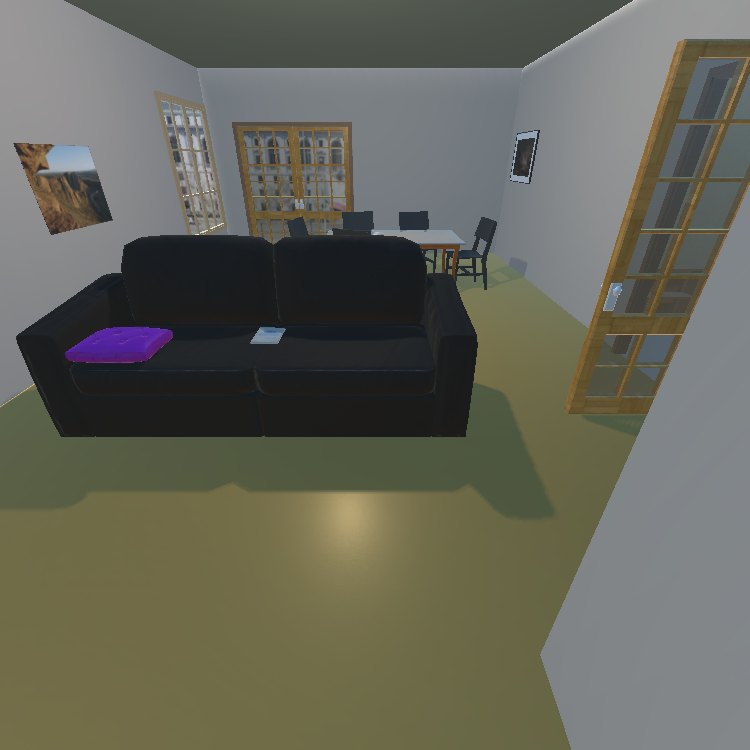

In [24]:
# grab img of an item to look for

# example: look for a tv in a room
event = controller.step(action="Teleport", position={'x': 2.75, 'y': 0.9009997844696045, 'z': 1.0})
Image.fromarray(event.frame)

In [25]:
human_room_description = (
    "there is a table. 5 chairs. there is a window. its probably a living room."
)
#Still need to use the room description.

In [26]:
print(HUMAN + ">" + human_room_description)
leolaniClient._add_utterance(HUMAN, human_room_description)

Human>there is a table. 5 chairs. there is a window. its probably a living room.


In [27]:
# claryfying questions
claryfying_questions_response = analyze_prompt(
    api_key=api_key,
    model="gpt-4o-mini",
    prompt=f"Imagine you are a robot who needs to be on a exact location as the point of view that the human has. After a while, the human can no longer see this image. The human will most likely describe a room from memory. The human will most likely describe a few objects and maybe some other attributes, like colours of objects. Your task is to ask claryfing questions about the room and objects so that you (the robot) has the highest chance of finding where the human was standing. Remember, ask the questions as if you were directly talking to the human. Try not to ask for too much details and dont ask for too much; remember, the human has to describe the image from memory, so only ask what you deem most important. \n Human description: {human_room_description}",
)

In [28]:
claryfying_questions_response

({'id': 'chatcmpl-Aam9RgXF5zYgH7ZhJdWedKt3Msiak',
  'object': 'chat.completion',
  'created': 1733328265,
  'model': 'gpt-4o-mini-2024-07-18',
  'choices': [{'index': 0,
    'message': {'role': 'assistant',
     'content': 'Thank you for describing the room! Can you tell me more about the table? What shape is it, and what color is it? Also, are there any decorations or items on the table?',
     'refusal': None},
    'logprobs': None,
    'finish_reason': 'stop'}],
  'usage': {'prompt_tokens': 183,
   'completion_tokens': 39,
   'total_tokens': 222,
   'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0},
   'completion_tokens_details': {'reasoning_tokens': 0,
    'audio_tokens': 0,
    'accepted_prediction_tokens': 0,
    'rejected_prediction_tokens': 0}},
  'system_fingerprint': 'fp_0705bf87c0'},
 0.8238227367401123)

In [29]:
utterance = claryfying_questions_response[0]["choices"][0]["message"]["content"]
print(AGENT + ">" + utterance)
leolaniClient._add_utterance(AGENT, utterance)

Ai2Thor>Thank you for describing the room! Can you tell me more about the table? What shape is it, and what color is it? Also, are there any decorations or items on the table?


In [30]:
human_room_description_clarified = "The table is blue, chairs are all black. The window is on the left wall in the same corner as th balcony doors."
print(HUMAN + ">" + human_room_description_clarified)
leolaniClient._add_utterance(HUMAN, human_room_description)

Human>The table is blue, chairs are all black. The window is on the left wall in the same corner as th balcony doors.


In [31]:
utterance = "Describe the object I should look for."
print(AGENT + ">" + utterance)
leolaniClient._add_utterance(AGENT, utterance)

Ai2Thor>Describe the object I should look for.


In [32]:
human_obj_description = "It's a dark painting with trees a moon. some clouds, a river."

In [33]:
print(HUMAN + ">" + human_obj_description)
leolaniClient._add_utterance(HUMAN, human_room_description)

Human>It's a dark painting with trees a moon. some clouds, a river.


In [34]:
# this is where the interactive object match comes :
# based on "dark painting with trees ...", did you mean "Painting"?

human_object_description = human_obj_description
matched_object = interactive_object_match(
    api_key=api_key,
    human_object_description=human_object_description,
    unique_object_list=unique_object_list,
    HUMAN=HUMAN,
    AGENT=AGENT,
    leolaniClient=leolaniClient,
)

Ai2Thor>To be sure, would you describe your object as Painting?
Ai2Thor>Is this correct? (yes/no): 
yes
Human>yes
Ai2Thor>Great! Object successfully matched.


In [35]:
matched_object

'Painting'

# THE LOOP





Teleporting the agent to {'x': 2.25, 'y': 0.9009997844696045, 'z': 4.75}  with rotation 222


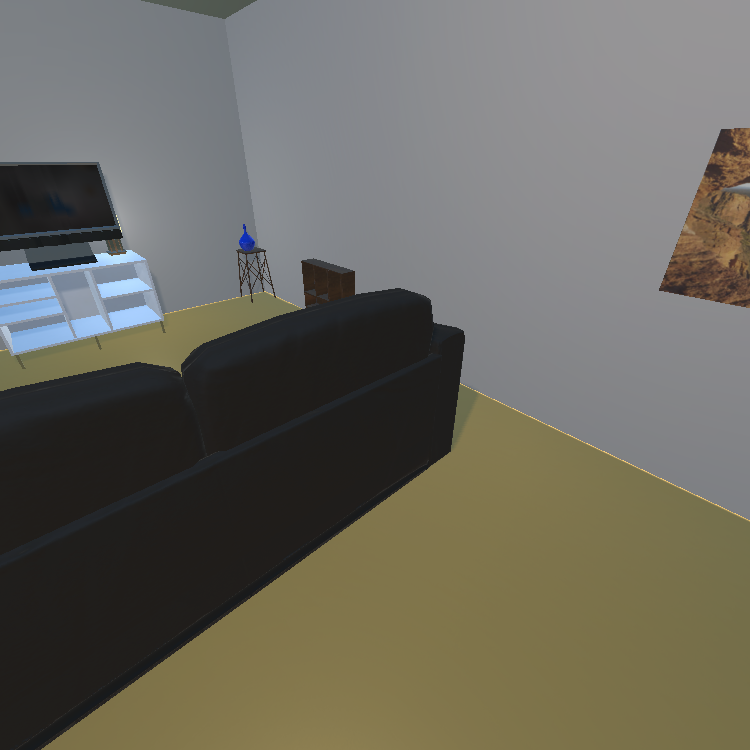

In [36]:
# Teleport somewhere random (Only happens once at the start)
import random
visited_positions = []
position = random.choice(reachable_positions)
rotation = random.choice(range(360))
print("Teleporting the agent to", position, " with rotation", rotation)

event = controller.step(action="Teleport", position=position, rotation=rotation)
agent_position = controller.last_event.metadata['agent']['position']
visited_positions.append(agent_position)

Image.fromarray(event.frame) # image for clearity

Painting|3|5 {'x': 0.004995774477720261, 'y': 1.3465479612350464, 'z': 4.775585651397705}
Painting|3|5 {'x': 0.004995774477720261, 'y': 1.3465479612350464, 'z': 4.775585651397705}
Painting|3|6 {'x': 5.0281662940979, 'y': 1.585843563079834, 'z': 7.616852760314941}
Ai2Thor>This is an image of a breathtaking landscape, likely a photo or digital rendering rather than a painting. It features towering rock formations standing prominently against a backdrop of open sky. The rocks exhibit shades of orange and brown, indicating the warmth of the setting or rising sun. 

The foreground includes a wedge-shaped rock on the left side. The middle ground reveals a river winding its way through the terrain on the right side, accentuating the natural beauty of the scene. In the distance, vast flatlands stretch Was this the item you were looking for?
Type 'yes' if so, or 'no' to continue: no
Human>no
Ai2Thor>The painting depicts a serene night scene, dominated by a large, luminous moon that bathes the l

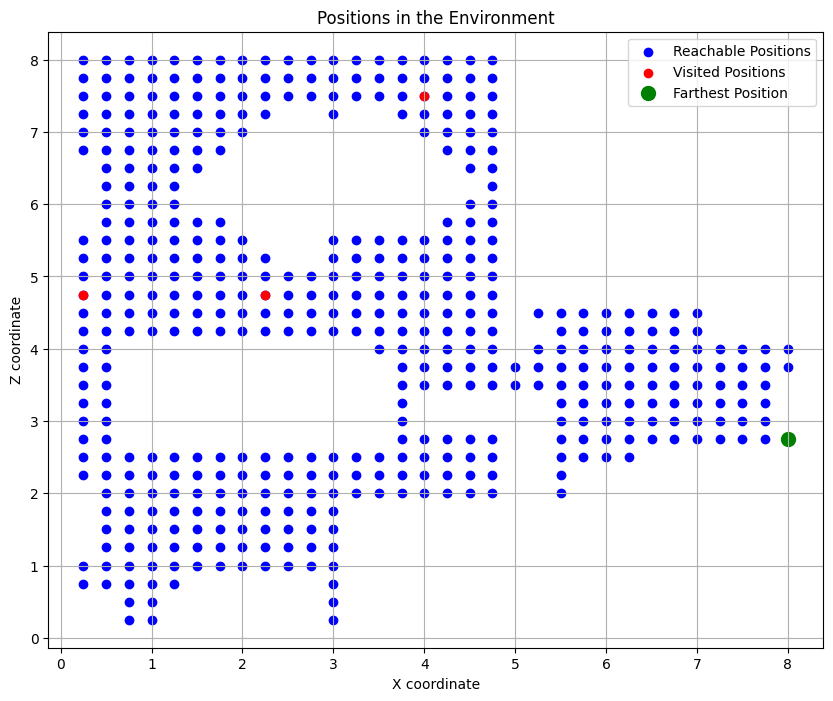

Teleporting to position: {'x': 8.0, 'y': 0.9009997844696045, 'z': 2.75}
Painting|3|5 {'x': 0.004995774477720261, 'y': 1.3465479612350464, 'z': 4.775585651397705}
Teleporting to a new location to continue the search.


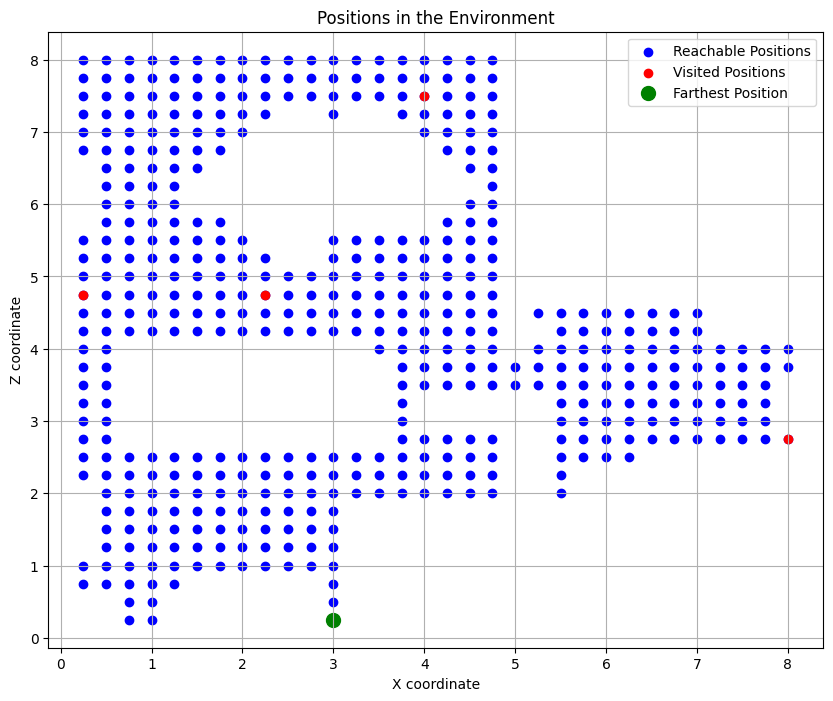

Teleporting to position: {'x': 3.0, 'y': 0.9009997844696045, 'z': 0.25}
Painting|3|5 {'x': 0.004995774477720261, 'y': 1.3465479612350464, 'z': 4.775585651397705}
Teleporting to a new location to continue the search.


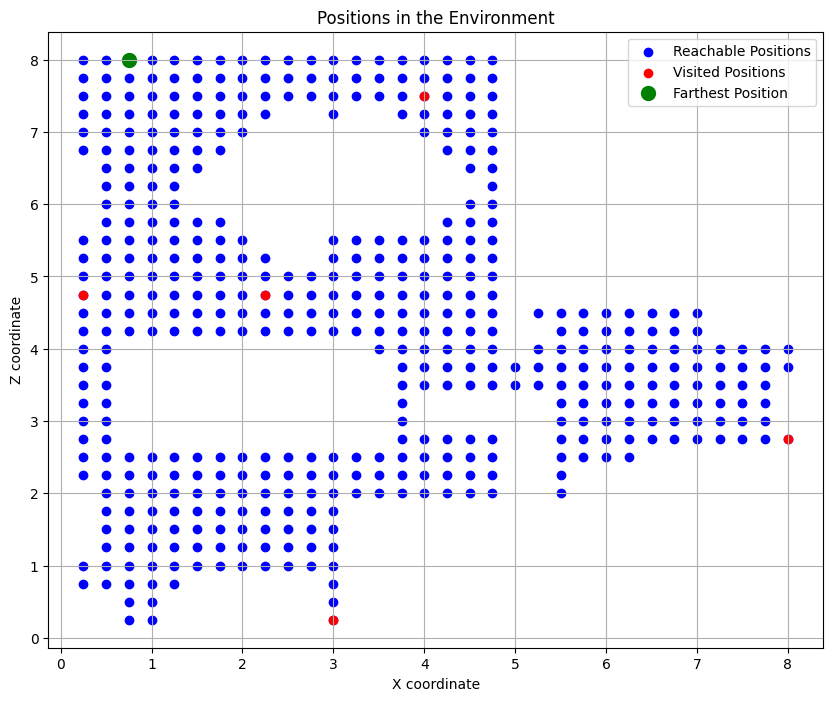

Teleporting to position: {'x': 0.75, 'y': 0.9009997844696045, 'z': 8.0}
Painting|3|5 {'x': 0.004995774477720261, 'y': 1.3465479612350464, 'z': 4.775585651397705}
Teleporting to a new location to continue the search.


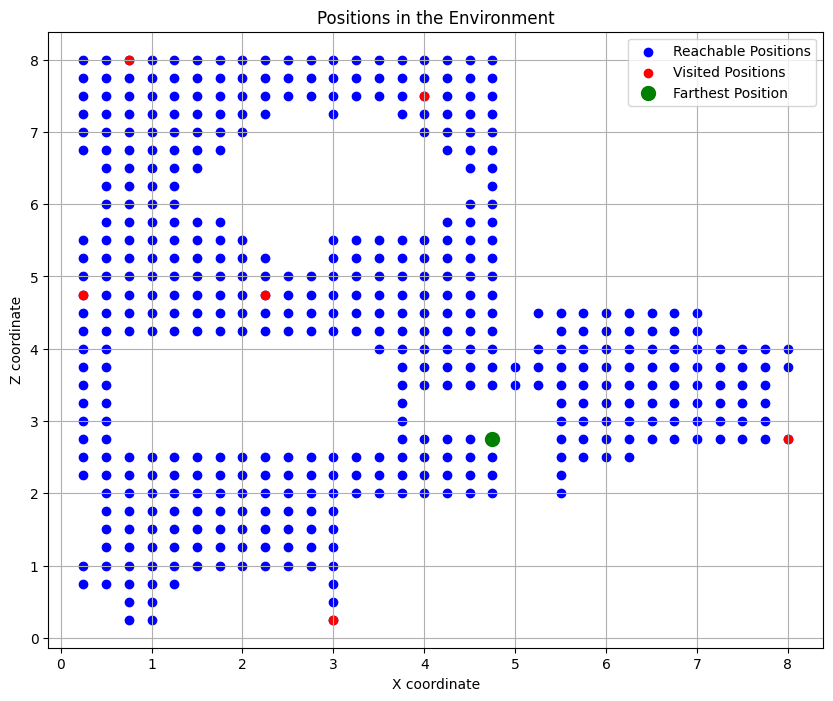

Teleporting to position: {'x': 4.75, 'y': 0.9009997844696045, 'z': 2.75}
Painting|3|5 {'x': 0.004995774477720261, 'y': 1.3465479612350464, 'z': 4.775585651397705}
Teleporting to a new location to continue the search.


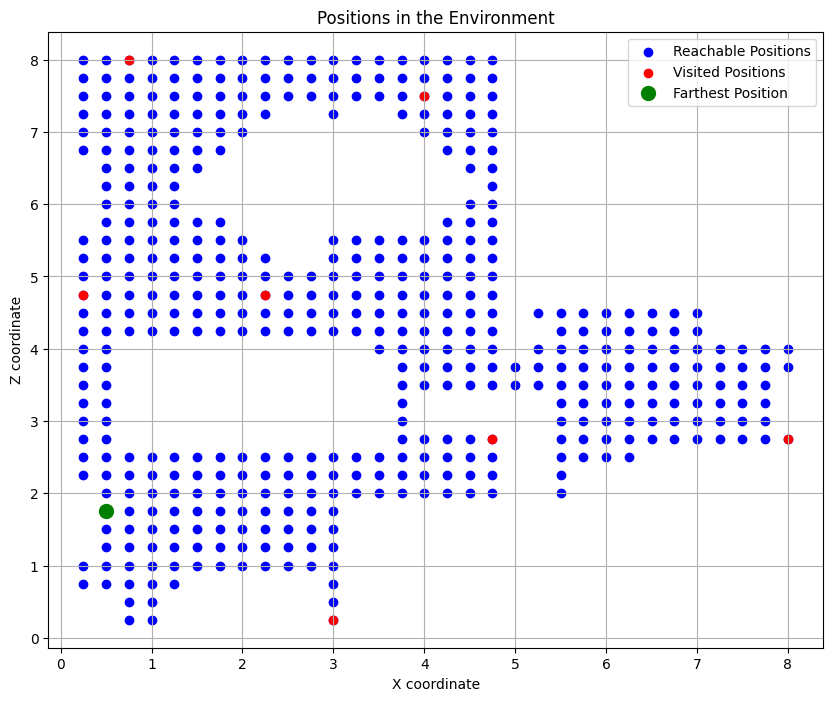

Teleporting to position: {'x': 0.5, 'y': 0.9009997844696045, 'z': 1.75}
Painting|3|5 {'x': 0.004995774477720261, 'y': 1.3465479612350464, 'z': 4.775585651397705}
Painting|3|6 {'x': 5.0281662940979, 'y': 1.585843563079834, 'z': 7.616852760314941}
Teleporting to a new location to continue the search.


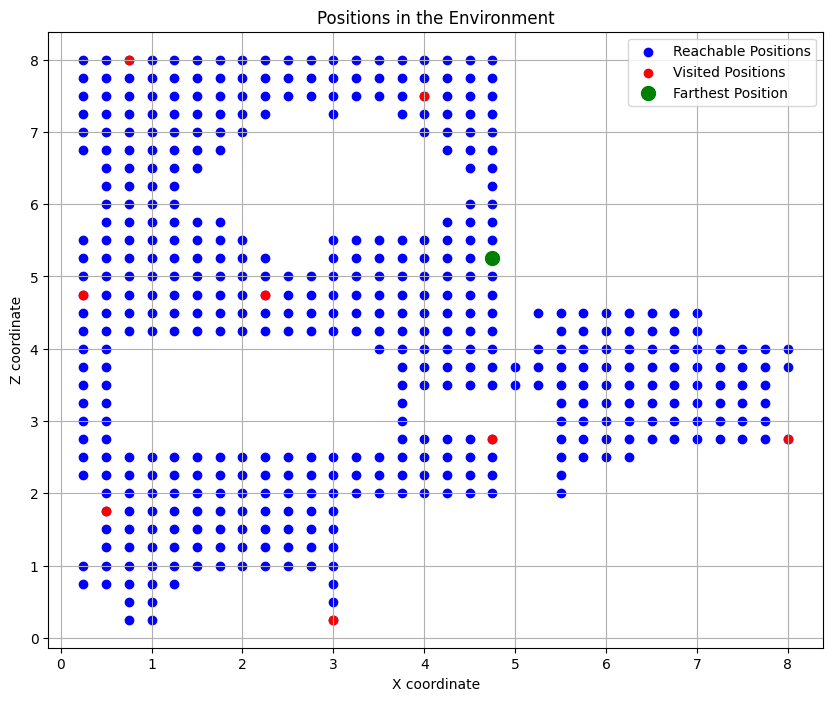

Teleporting to position: {'x': 4.75, 'y': 0.9009997844696045, 'z': 5.25}
Painting|3|5 {'x': 0.004995774477720261, 'y': 1.3465479612350464, 'z': 4.775585651397705}
Painting|3|5 {'x': 0.004995774477720261, 'y': 1.3465479612350464, 'z': 4.775585651397705}
Painting|3|6 {'x': 5.0281662940979, 'y': 1.585843563079834, 'z': 7.616852760314941}
Teleporting to a new location to continue the search.


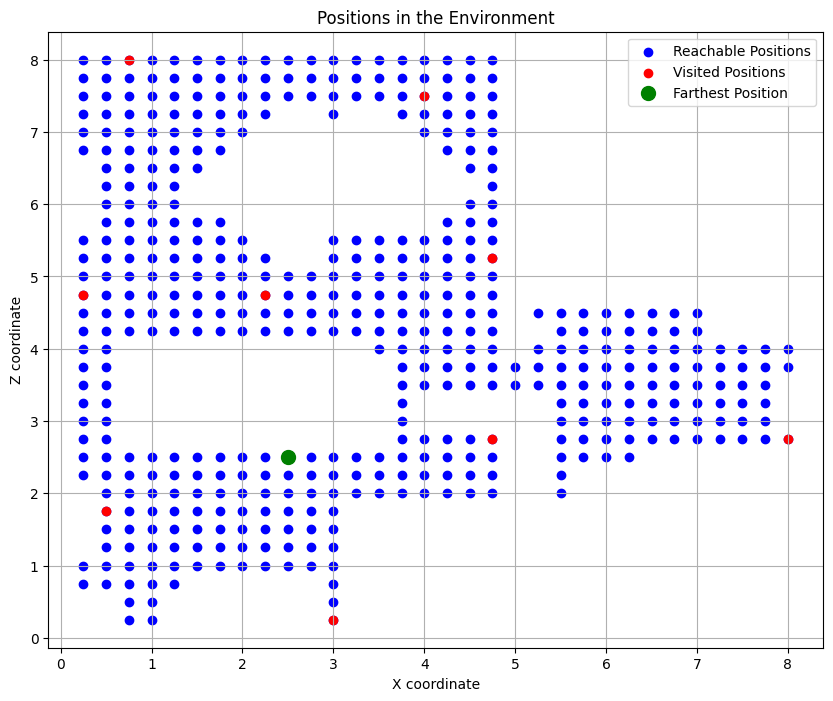

Teleporting to position: {'x': 2.5, 'y': 0.9009997844696045, 'z': 2.5}
Painting|3|5 {'x': 0.004995774477720261, 'y': 1.3465479612350464, 'z': 4.775585651397705}
Painting|3|6 {'x': 5.0281662940979, 'y': 1.585843563079834, 'z': 7.616852760314941}
Teleporting to a new location to continue the search.


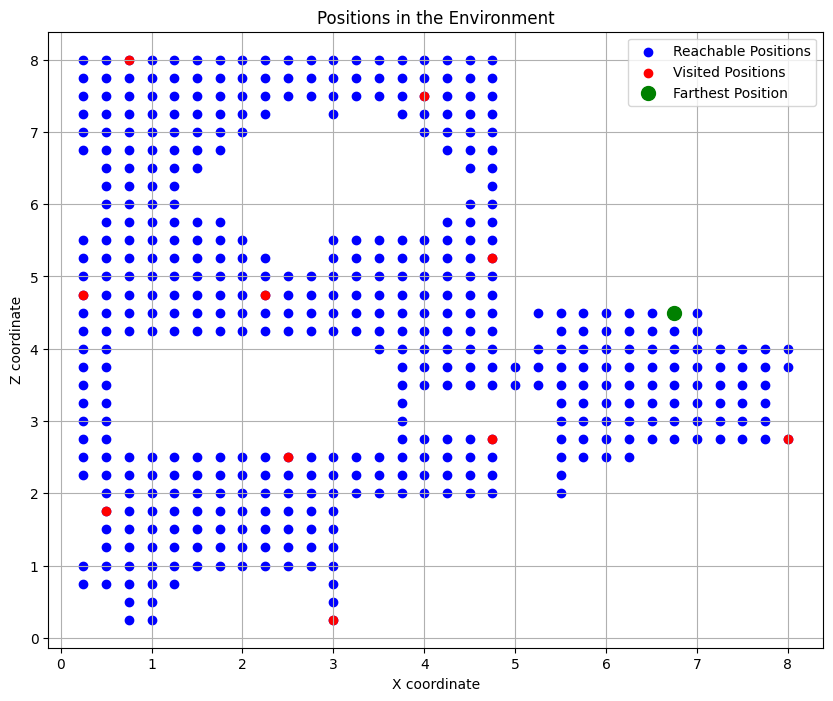

Teleporting to position: {'x': 6.75, 'y': 0.9009997844696045, 'z': 4.5}


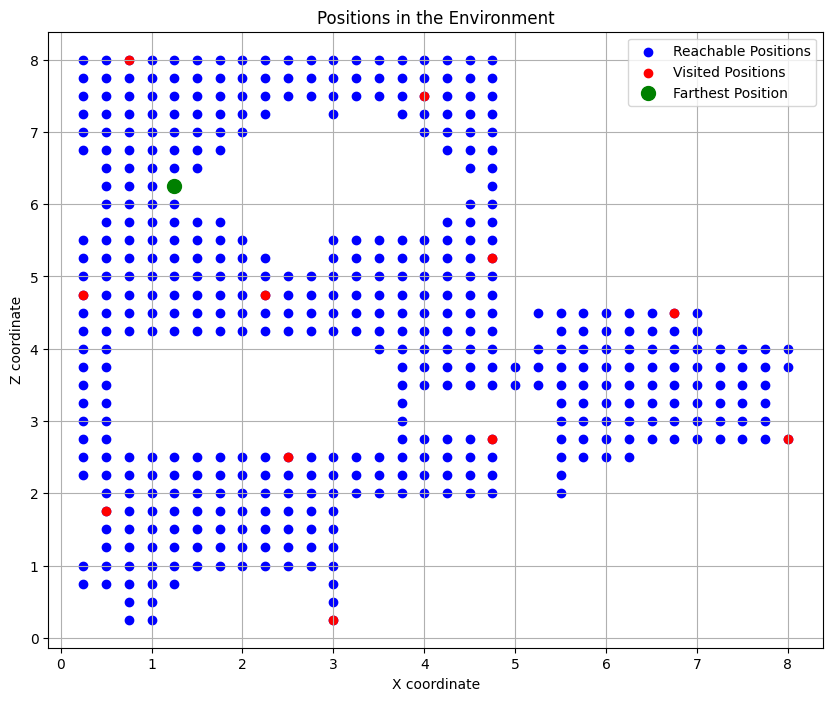

Teleporting to a new location to continue the search.
Teleporting to position: {'x': 1.25, 'y': 0.9009997844696045, 'z': 6.25}
Painting|3|5 {'x': 0.004995774477720261, 'y': 1.3465479612350464, 'z': 4.775585651397705}
Painting|3|6 {'x': 5.0281662940979, 'y': 1.585843563079834, 'z': 7.616852760314941}
Teleporting to a new location to continue the search.


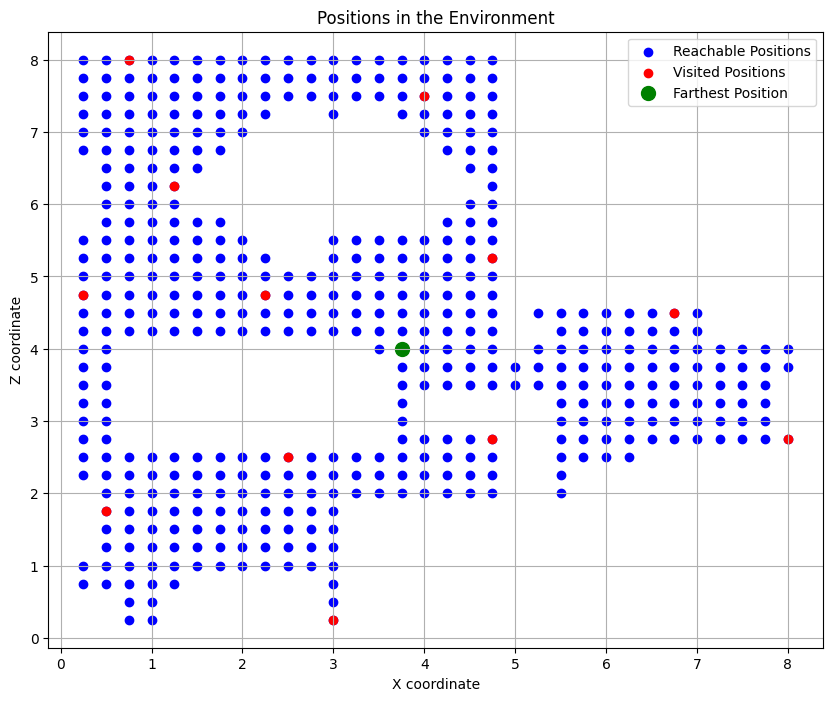

Teleporting to position: {'x': 3.75, 'y': 0.9009997844696045, 'z': 4.0}
Painting|3|5 {'x': 0.004995774477720261, 'y': 1.3465479612350464, 'z': 4.775585651397705}
Painting|3|6 {'x': 5.0281662940979, 'y': 1.585843563079834, 'z': 7.616852760314941}
Teleporting to a new location to continue the search.


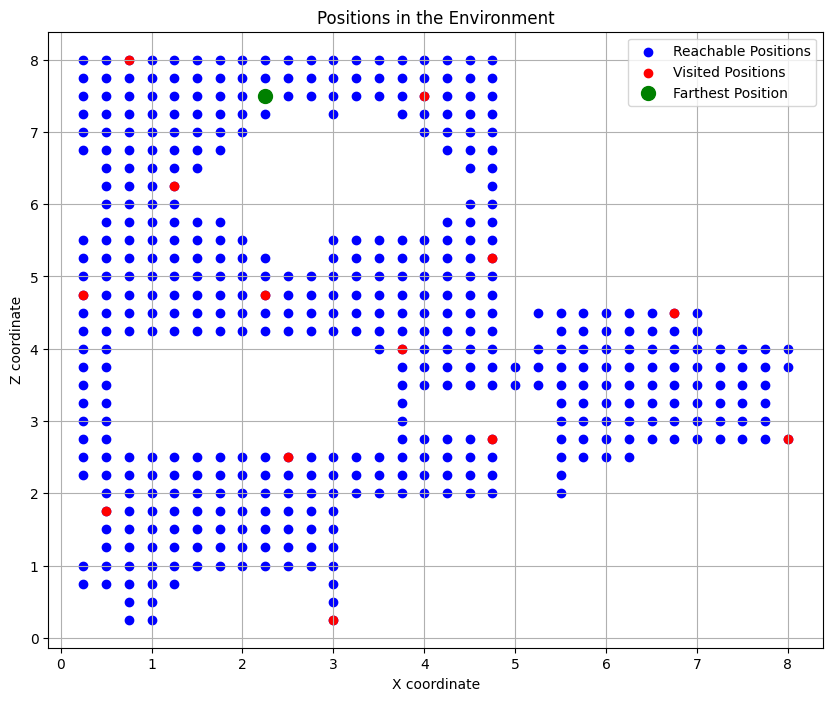

Teleporting to position: {'x': 2.25, 'y': 0.9009997844696045, 'z': 7.5}
Painting|3|5 {'x': 0.004995774477720261, 'y': 1.3465479612350464, 'z': 4.775585651397705}
Painting|3|6 {'x': 5.0281662940979, 'y': 1.585843563079834, 'z': 7.616852760314941}
Teleporting to a new location to continue the search.


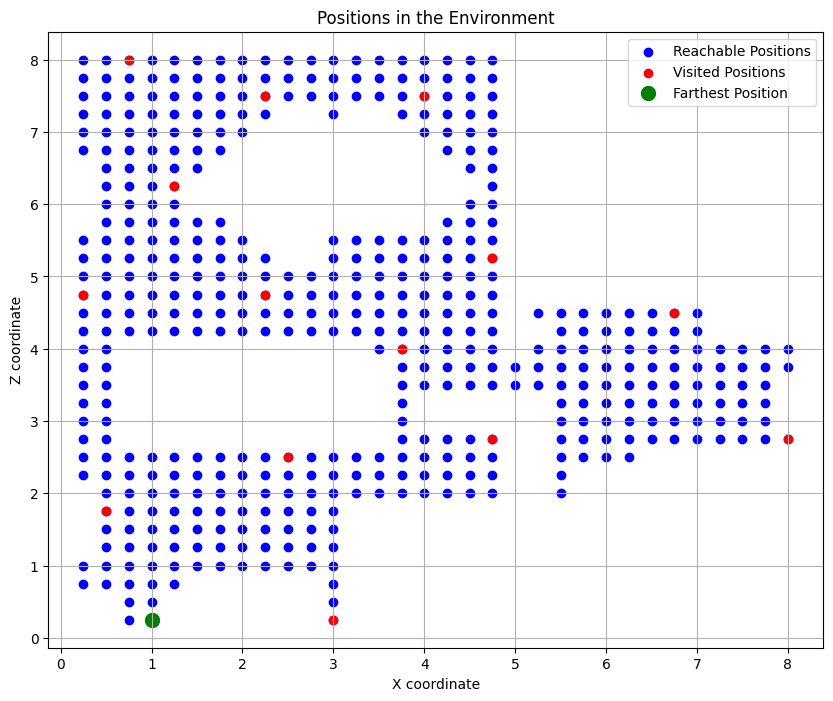

Teleporting to position: {'x': 1.0, 'y': 0.9009997844696045, 'z': 0.25}
Painting|3|5 {'x': 0.004995774477720261, 'y': 1.3465479612350464, 'z': 4.775585651397705}
Painting|3|6 {'x': 5.0281662940979, 'y': 1.585843563079834, 'z': 7.616852760314941}
Teleporting to a new location to continue the search.


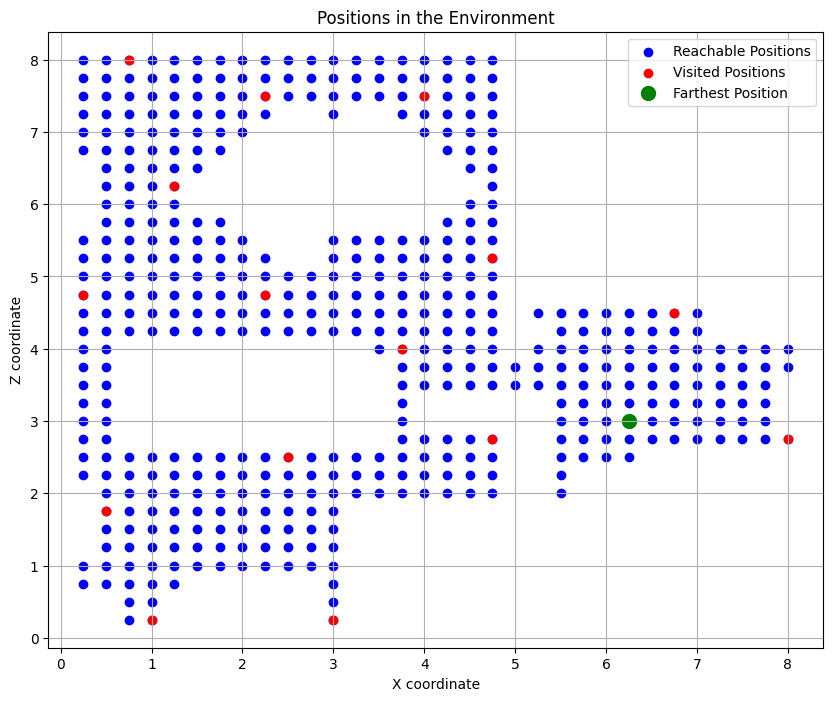

Teleporting to position: {'x': 6.25, 'y': 0.9009997844696045, 'z': 3.0}
Painting|3|5 {'x': 0.004995774477720261, 'y': 1.3465479612350464, 'z': 4.775585651397705}
Teleporting to a new location to continue the search.


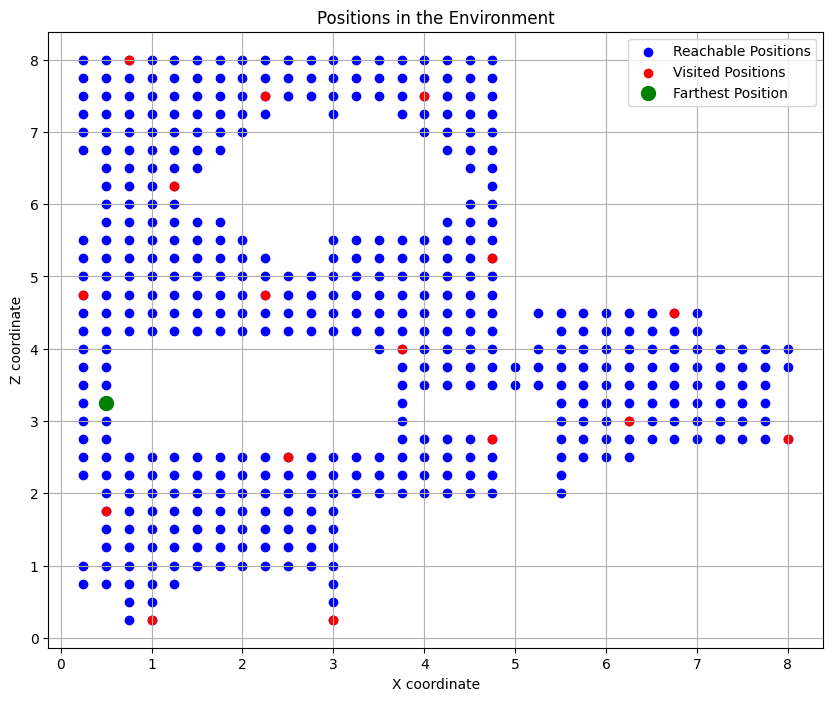

Teleporting to position: {'x': 0.5, 'y': 0.9009997844696045, 'z': 3.25}
Painting|3|5 {'x': 0.004995774477720261, 'y': 1.3465479612350464, 'z': 4.775585651397705}
Painting|3|6 {'x': 5.0281662940979, 'y': 1.585843563079834, 'z': 7.616852760314941}
Teleporting to a new location to continue the search.


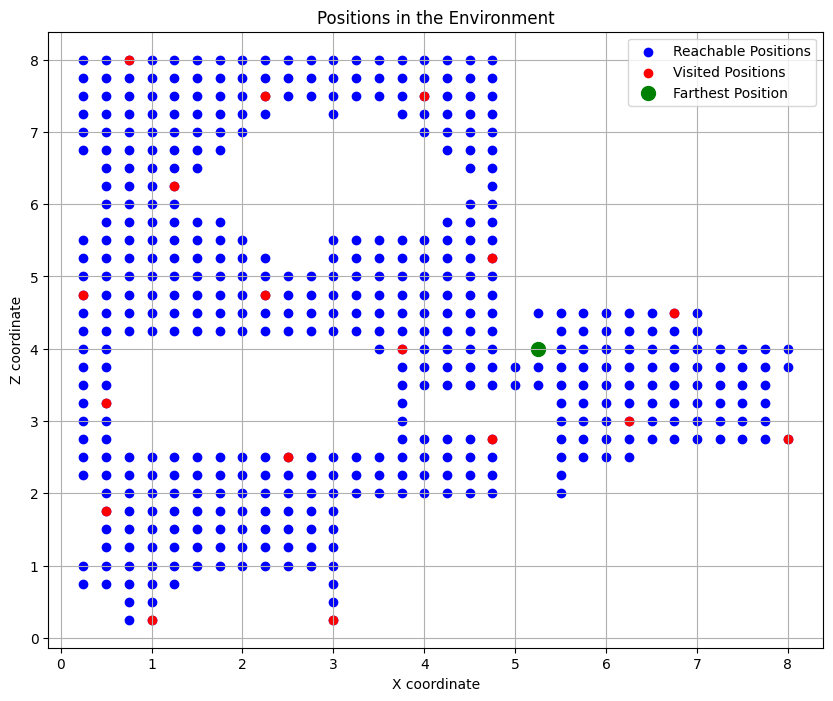

Teleporting to position: {'x': 5.25, 'y': 0.9009997844696045, 'z': 4.0}
Painting|3|5 {'x': 0.004995774477720261, 'y': 1.3465479612350464, 'z': 4.775585651397705}
Teleporting to a new location to continue the search.


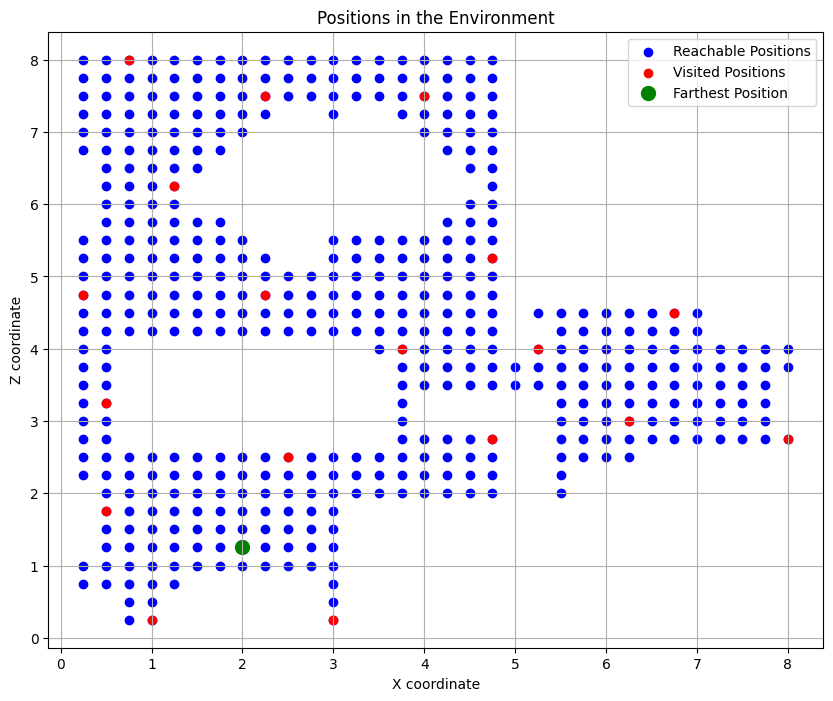

Teleporting to position: {'x': 2.0, 'y': 0.9009997844696045, 'z': 1.25}
Painting|3|5 {'x': 0.004995774477720261, 'y': 1.3465479612350464, 'z': 4.775585651397705}
Painting|3|6 {'x': 5.0281662940979, 'y': 1.585843563079834, 'z': 7.616852760314941}
Teleporting to a new location to continue the search.


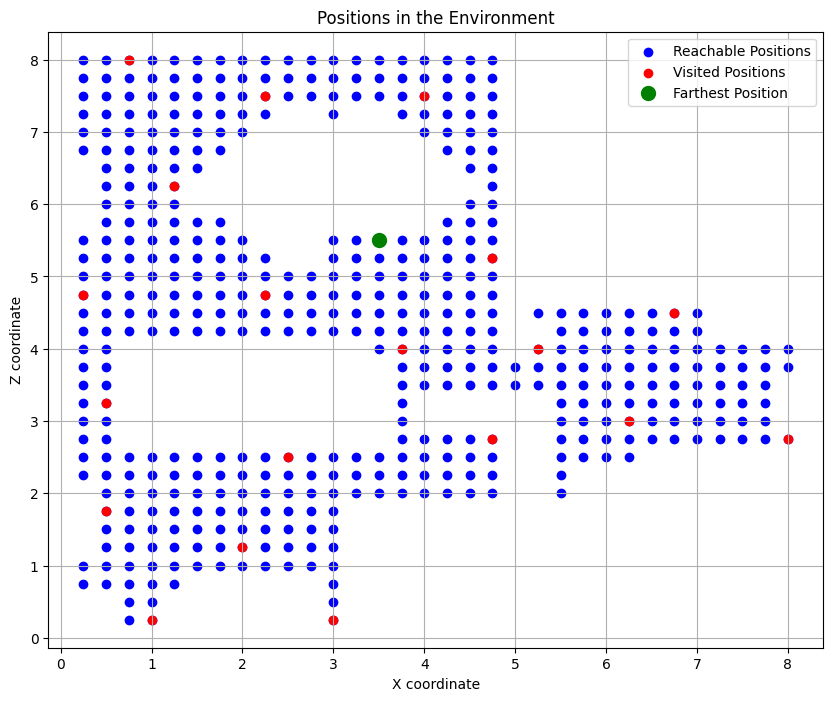

Teleporting to position: {'x': 3.5, 'y': 0.9009997844696045, 'z': 5.5}
Painting|3|5 {'x': 0.004995774477720261, 'y': 1.3465479612350464, 'z': 4.775585651397705}
Painting|3|6 {'x': 5.0281662940979, 'y': 1.585843563079834, 'z': 7.616852760314941}
Teleporting to a new location to continue the search.


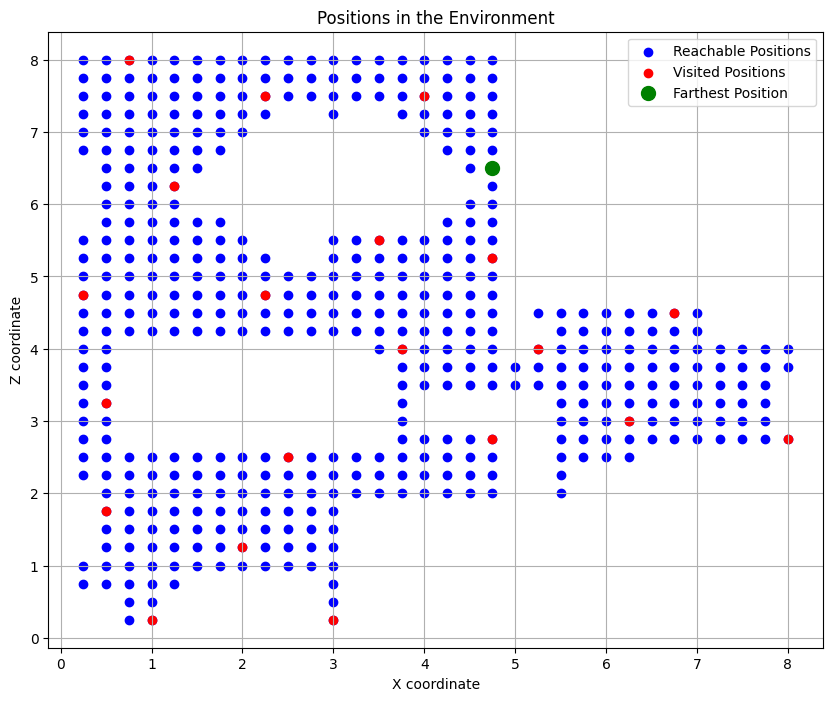

Teleporting to position: {'x': 4.75, 'y': 0.9009997844696045, 'z': 6.5}
Painting|3|5 {'x': 0.004995774477720261, 'y': 1.3465479612350464, 'z': 4.775585651397705}
Painting|3|6 {'x': 5.0281662940979, 'y': 1.585843563079834, 'z': 7.616852760314941}
Teleporting to a new location to continue the search.


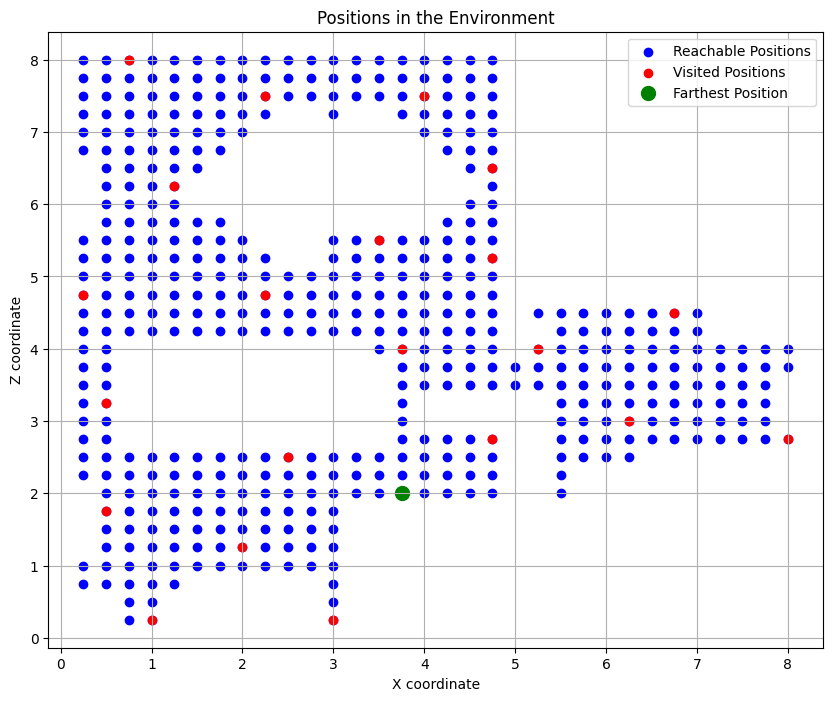

Teleporting to position: {'x': 3.75, 'y': 0.9009997844696045, 'z': 2.0}
Painting|3|5 {'x': 0.004995774477720261, 'y': 1.3465479612350464, 'z': 4.775585651397705}
Painting|3|6 {'x': 5.0281662940979, 'y': 1.585843563079834, 'z': 7.616852760314941}
Teleporting to a new location to continue the search.


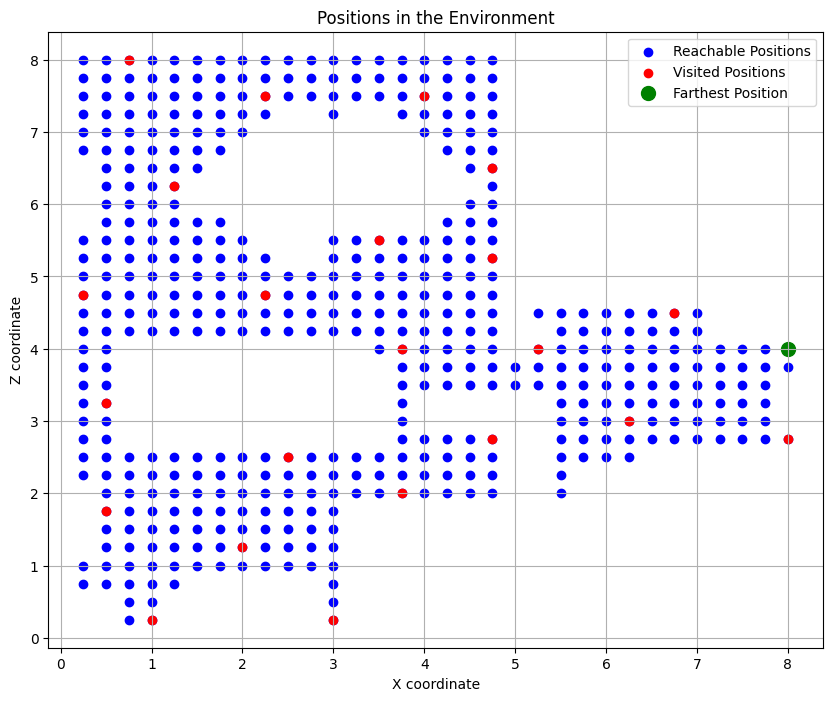

Teleporting to position: {'x': 8.0, 'y': 0.9009997844696045, 'z': 4.0}


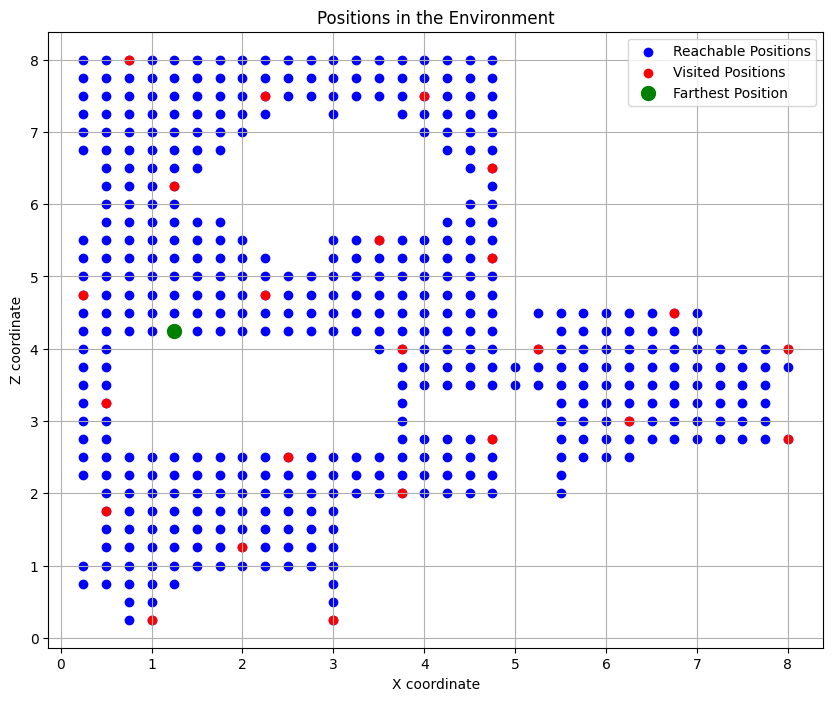

Teleporting to a new location to continue the search.
Teleporting to position: {'x': 1.25, 'y': 0.9009997844696045, 'z': 4.25}
Painting|3|5 {'x': 0.004995774477720261, 'y': 1.3465479612350464, 'z': 4.775585651397705}
Painting|3|6 {'x': 5.0281662940979, 'y': 1.585843563079834, 'z': 7.616852760314941}
Teleporting to a new location to continue the search.


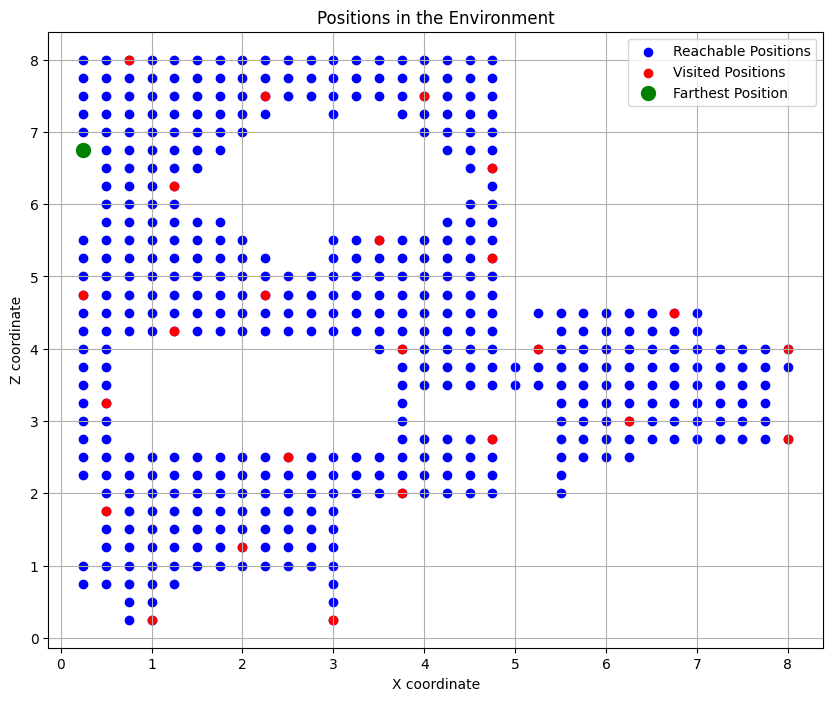

Teleporting to position: {'x': 0.25, 'y': 0.9009997844696045, 'z': 6.75}
Painting|3|5 {'x': 0.004995774477720261, 'y': 1.3465479612350464, 'z': 4.775585651397705}
Painting|3|6 {'x': 5.0281662940979, 'y': 1.585843563079834, 'z': 7.616852760314941}
Teleporting to a new location to continue the search.


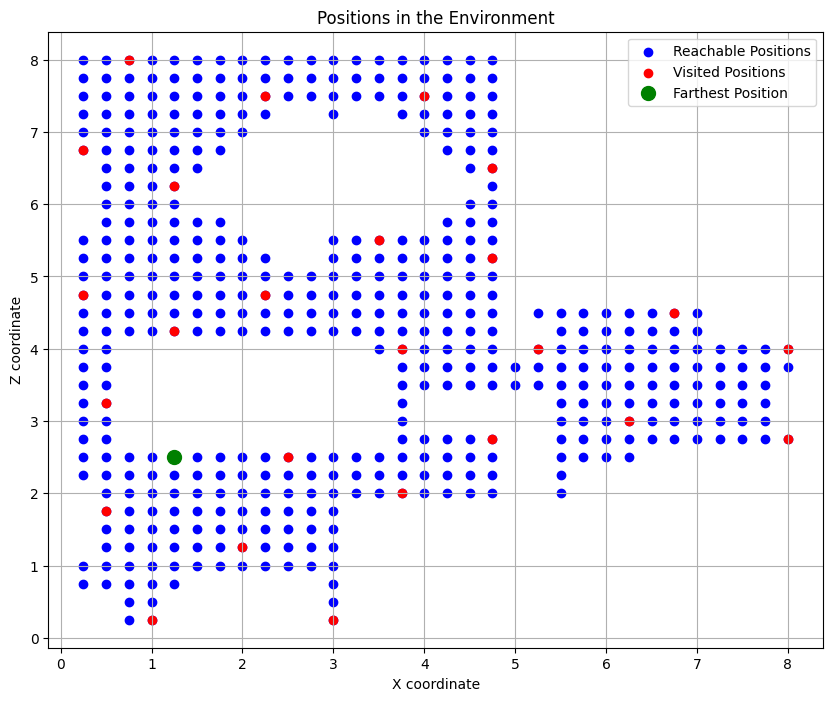

Teleporting to position: {'x': 1.25, 'y': 0.9009997844696045, 'z': 2.5}
Painting|3|5 {'x': 0.004995774477720261, 'y': 1.3465479612350464, 'z': 4.775585651397705}
Painting|3|6 {'x': 5.0281662940979, 'y': 1.585843563079834, 'z': 7.616852760314941}
Teleporting to a new location to continue the search.


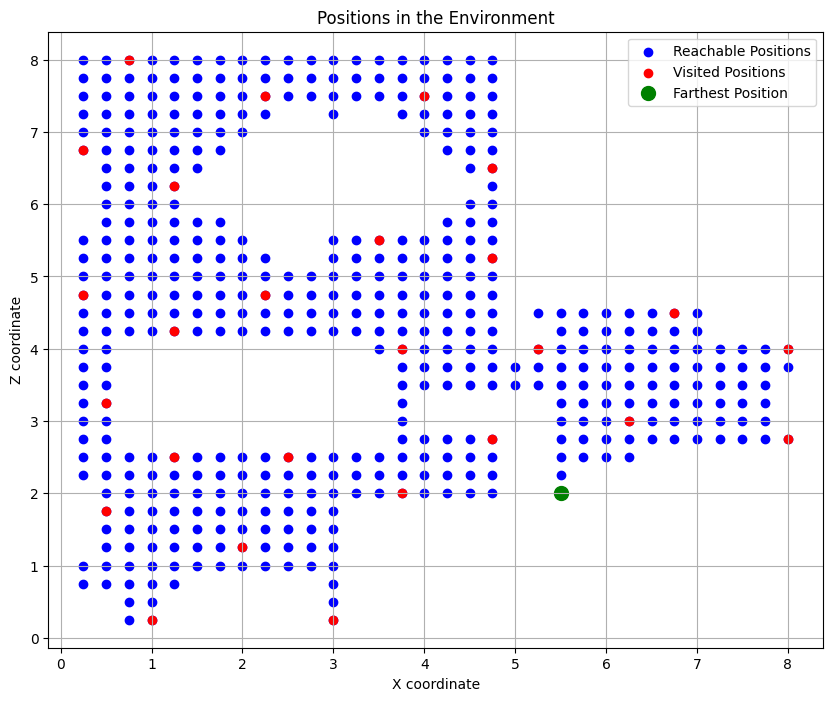

Teleporting to position: {'x': 5.5, 'y': 0.9009997844696045, 'z': 2.0}
Painting|2|6 {'x': 8.383004188537598, 'y': 1.8958626985549927, 'z': 2.2807140350341797}
Ai2Thor>The painting on the wall appears to depict a vast, desert-like landscape. It showcases an arid terrain with rolling sand dunes stretching into the distance. The colors are warm, with varying shades of brown and ochre, creating a sense of depth and texture. The dunes are marked by shadows that enhance their form and give the scene a dynamic feel. In the center, there is a winding river or waterway, reflecting the light and adding contrast to the dry surroundings. The landscape is framed neatly and Was this the item you were looking for?
Type 'yes' if so, or 'no' to continue: yes
Human>yes
Ai2Thor>Great! I've found the Painting.
Successfully found the object.


In [37]:
found = find_object_and_confirm(
    controller=controller,
    matched_object=matched_object,
    reachable_positions=reachable_positions,
    api_key=api_key,
    AGENT=AGENT,
    HUMAN=HUMAN,
    leolaniClient=leolaniClient,
    visited_positions=visited_positions
)

if found:
    print("Successfully found the object.")
else:
    print("Object not found after searching all locations.")

In [38]:
##### After completion, we save the scenario in the defined emissor folder.
leolaniClient._save_scenario()

#TESTING

In [39]:
# location classificaiton; We don't use this yet:

# chatgpt, do you think you are in the correct room based on human_room_description + human_room description_clarified? (maybe rotate 360 degrees, but also have to analyze 4 images then)

room_classifcation = analyze_image(
    base64_string,
    api_key=api_key,
    prompt=f"Imagine you are a robot looking for a certain room. Describe the room shortly. Do you think you are in the correct room based on the following description? Description: {human_room_description}, even further description: {human_room_description_clarified}, speak to me as if you have the robots point of view. Be consise in your answer.",
)
utterance = room_classifcation[0]["choices"][0]["message"]["content"]
print(AGENT + ">" + utterance)
leolaniClient._add_utterance(AGENT, utterance)

Ai2Thor>As a robot, I see a room that matches the description well. There is a table, which appears to be blue, surrounded by five black chairs. A window is on the left wall, near the balcony doors. This aligns with the provided details. I believe I am in the correct room.


In [40]:
visible_objects = [
    obj for obj in controller.last_event.metadata["objects"] if obj["visible"]
]
matched_objects = [obj for obj in visible_objects if obj["objectType"] == matched_object]
all_matched_object_positions = []  # To store all matchedobject positions

for _ in range(3):  # Rotate three times
    # Get visible objects and their positions
    current_matched_object_positions = []
    for matched_object in matched_objects:
        print(matched_object["name"], matched_object["position"])
        current_matched_object_positions.append(matched_object["position"])

    # Add current painting positions to the overall list
    all_matched_object_positions.extend(current_matched_object_positions)

    # Rotate the agent
    controller.step("RotateRight")

    # Update visible objects and paintings for the next iteration
    visible_objects = [
        obj for obj in controller.last_event.metadata["objects"] if obj["visible"]
    ]
    matched_objects = [obj for obj in visible_objects if obj["objectType"] == matched_objects]

print("All" + matched_object +"positions in the room:", all_matched_object_positions)

Painting|2|6 {'x': 8.383004188537598, 'y': 1.8958626985549927, 'z': 2.2807140350341797}


TypeError: can only concatenate str (not "dict") to str

RANDOM TELEPORT

In [ ]:
import random

position = random.choice(reachable_positions)
rotation = random.choice(range(360))
print("Teleporting the agent to", position, " with rotation", rotation)

event = controller.step(action="Teleport", position=position, rotation=rotation)
Image.fromarray(event.frame)

ROTATING AND REMEMBERING OBJECT LOCATIONS

IMAGE WITH 2 PAINTING

In [ ]:
event = controller.step(
    action="Teleport",
    position={"x": 2.5, "y": 0.9009997844696045, "z": 4.5},
    rotation=80,
)
Image.fromarray(event.frame)

LOOK UP / DOWN

In [ ]:
# controller.step("LookDown")
# Image.fromarray(controller.last_event.frame)

# after we take look up or down we should return to the original state, THIS IS IMPORTANT OTHERWISE IT WILL MESS WITH TELEPORTING

In [ ]:
def main():
    print("Setting up...")
    setup(env="local")
    load_dataset()
    # get_top_down_frame()
    controller = Controller(scene=house, visibilityDistance=10, width=750, height=750)
    event = controller.step(action="GetReachablePositions")
    reachable_positions = event.metadata["actionReturn"]
    init_chat_client()

    add_utterance(AGENT,f"Hi {HUMAN}. What do you see in the room?")